In [9]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math

from tensorflow.keras.datasets import cifar10
from tqdm import tqdm

(tr_x, _), (te_x, _) = cifar10.load_data()

tr_x = np.moveaxis(tr_x, 1, 3)
te_x = np.moveaxis(te_x, 1, 3)

In [2]:
def pop_code(img, pop_size, base_val=255):
  h, w, C = img.shape
  pop_del = base_val / pop_size

  # We include populations for both on and off (both are signal here)
  pop_img = np.zeros((h, w * 2 * pop_size, C))

  for y in range(h):
    for x in range(w):
      for c in range(C):
        img_v = math.floor(img[y][x][c].item())
        img_pop_size = math.floor(img_v // pop_del)
        img_x = x * 2 * pop_size

        neg_start = img_x + pop_size

        # First do the ON values
        pop_img[y, img_x:(img_x + img_pop_size), c] = 1
        # Now do the OFF values
        pop_img[y, (neg_start):(neg_start + pop_size - img_pop_size), c] = 1
  
  return pop_img

In [3]:
def decode_pop(pop_img, pop_size, base_val=255, useInt=True, thresh=-1, toTensor=False):
  if thresh > 0:
    new_img = np.zeros(pop_img.shape)
    new_img[pop_img > thresh] = 1

    pop_img = new_img

  h, pop_w, C = pop_img.shape
  img_w = math.floor(pop_w / (2 * pop_size))

  img = np.zeros((h, img_w, C))

  for y in range(h):
    for x in range(img_w):
      for c in range(C):
        pop_x = 2 * pop_size * x

        pop_sum = np.sum(pop_img[y, pop_x:(pop_x + pop_size), c])

        img_val = (base_val * pop_sum / pop_size)

        img[y][x][c] = img_val

  if useInt:
    img = img.astype(int)

  if toTensor:
    return t.tensor(img)
  
  return img

In [10]:
def encode_dataset(dataset, pop_size, max_size=-1, base_val=255):
  all_imgs = []

  if max_size < 0:
    max_size = len(dataset)

  for img in tqdm(dataset[:max_size]):
    all_imgs.append(pop_code(img, pop_size, base_val))

  return np.array(all_imgs)

In [11]:
pop_size = 10

e_data = encode_dataset(tr_x, pop_size, max_size=100)

100%|██████████| 100/100 [00:01<00:00, 94.76it/s]


(-0.5, 31.5, 31.5, -0.5)

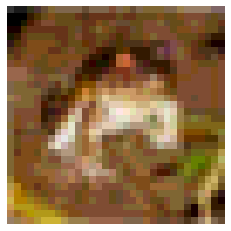

In [15]:
img = decode_pop(pop_data[0], pop_size, thresh=.9)

plt.imshow(img)
plt.axis("off")

In [13]:
pop_data = encode_dataset(tr_x, pop_size, max_size=10000)

100%|██████████| 10000/10000 [01:45<00:00, 94.54it/s]


In [14]:
def draw_color_weights(w, Kx, Ky, fig, s_len):
    tapestry = np.zeros((s_len * Kx, s_len * Ky, 3))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len, 3)
            w_i += 1
            
    plt.clf()        
    im = plt.imshow(tapestry / np.maximum(1e-10, np.max(tapestry)), vmin=0)
    plt.axis("off")
    fig.canvas.draw()

In [34]:
def draw_pop_weights(w, Kx, Ky, fig, s_len, pop_size, thresh):
    tapestry = np.zeros((s_len * Kx, s_len * Ky, 3))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = decode_pop(w[w_i].reshape(s_len, -1, 3), pop_size, thresh=thresh).reshape(s_len, s_len, 3)
            w_i += 1
            
    plt.clf()        
    im = plt.imshow(tapestry / np.maximum(1e-10, np.max(tapestry)), vmin=0)
    plt.axis("off")
    fig.canvas.draw()

In [16]:
big_data = pop_data

In [17]:
tr_x.shape

(50000, 32, 32, 3)

In [18]:
s_len = 10
slh = s_len // 2
sl2 = s_len * s_len

data = tr_x[:, 16 - slh: 16 + slh, 16 - slh: 16 + slh]

In [26]:
pop_data = encode_dataset(data, pop_size)

100%|██████████| 50000/50000 [00:51<00:00, 968.21it/s] 


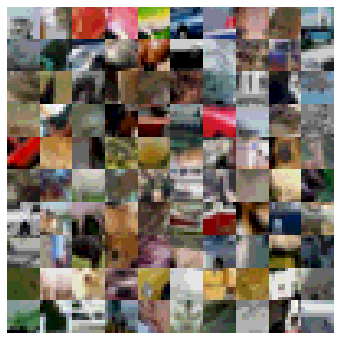

In [35]:
fig = plt.figure(figsize=(6, 6))
offset = 100
draw_pop_weights(pop_data[offset:offset + 100].reshape(100, -1), 10, 10, fig, 10, pop_size, .5)

In [31]:
gp_pop_data = cp.asarray(pop_data)

In [29]:
def gen_lat_ex(Kx, Ky, ex, coeff):

    lat_ex = []

    for y in range(Ky):
        for x in range(Kx):
            curr_ex = np.zeros((Ky, Kx))
            curr_ex[max(0, y - ex): min(Ky, y + ex + 1), max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if y - ex < 0:
                curr_ex[y - ex:, max(0, x - ex): min(Kx, x + ex + 1)] = 1
            if y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, max(0, x - ex): min(Kx, x + ex + 1)] = 1

            if x - ex < 0:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), x - ex:] = 1
            if x + ex + 1 > Kx:
                curr_ex[max(0, y - ex): min(Ky, y + ex + 1), :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x - ex < 0:
                curr_ex[y - ex:, x - ex:] = 1

            if x + ex + 1 > Kx and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, :x + ex + 1 - Kx] = 1

            if y - ex < 0 and x + ex + 1 > Kx:
                curr_ex[y - ex:, :x + ex + 1 - Kx] = 1


            if x - ex < 0 and y + ex + 1 > Ky:
                curr_ex[:y + ex + 1 - Ky, x - ex:] = 1

            lat_ex.append(curr_ex.reshape(-1))

    lat_ex = cp.array(lat_ex)
    np.fill_diagonal(lat_ex, 0)

    lat_ex = (lat_ex / cp.linalg.norm(lat_ex, axis=1).reshape(-1, 1)) * coeff
    np.fill_diagonal(lat_ex, 1)
    
    return lat_ex

<IPython.core.display.Javascript object>


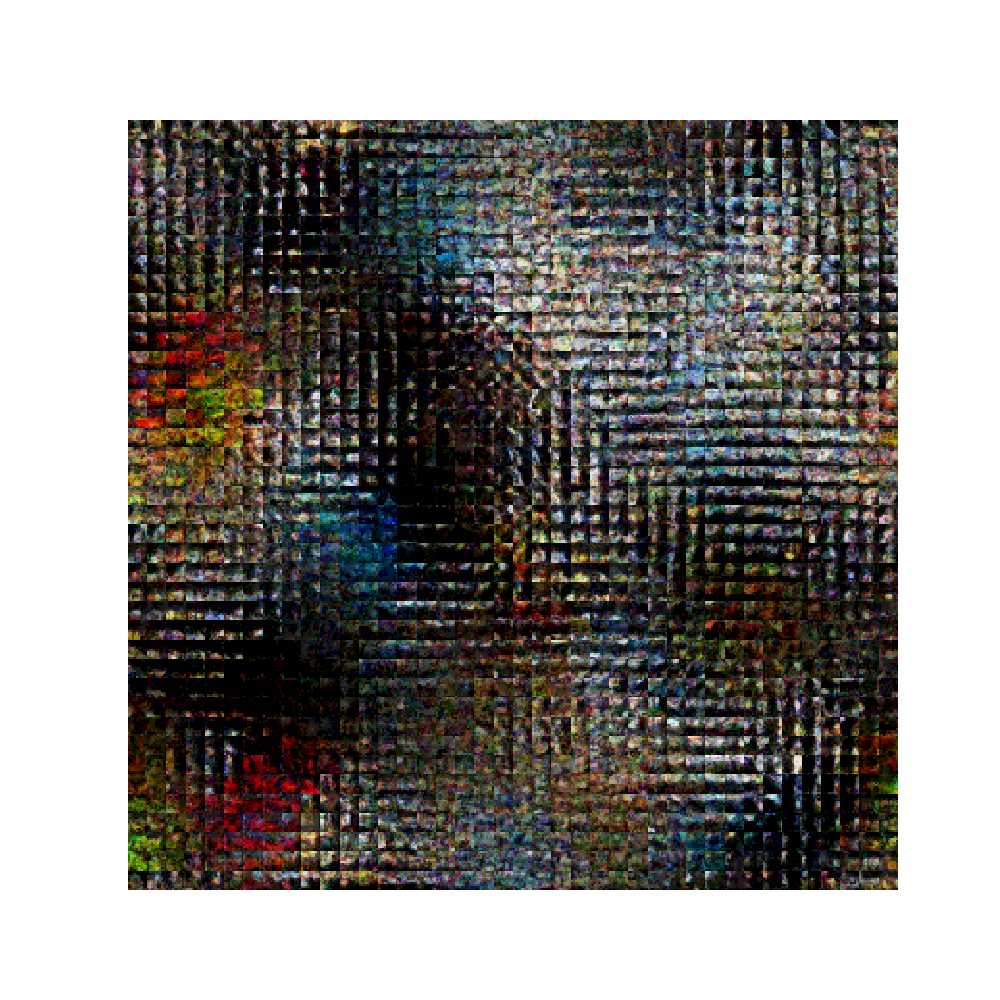

 30%|██▉       | 1497/5000 [00:02<00:06, 550.53it/s]

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 40
T_s = 5_000

Kx = 40
Ky = 40
N = Kx * Ky
m_len = sl2 * 3
tr_len = 50_000
ex = 2
coeff = 0.5

prec = 1e-10

n_w = 40 #Number of winners

# Feedforward
w = cp.random.uniform(.15, .2, (N, m_len * 2 * pop_size))
xi = 0.05

lat_ex = gen_lat_ex(Kx, Ky, ex, coeff)

for ep in range(Nep):
    inputs = gp_pop_data[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        p = w @ v
        c = p + (lat_ex @ p)
        winners = cp.argsort(c, axis=0)[-n_w:]
        mask = cp.zeros((N, 1))
        mask[winners] = 1
        o = mask * p
        r = w.T @ o
        mod_r = cp.maximum(r, prec)
        e = cp.clip(v - r, -1, 1)
        
        w += w * o * (e / mod_r).T * xi
        
        if i % 500 == 0:
            w += cp.random.uniform(0, float(cp.mean(w)) * .05, (N, m_len * 2 * pop_size))
        
        cp.clip(w, 0, 1, out=w)
        
    draw_pop_weights(w.get(), Kx, Ky, fig, s_len, pop_size, float(cp.mean(w)))

In [58]:
cp.max(w[3])

array(0.09565772)

<IPython.core.display.Javascript object>


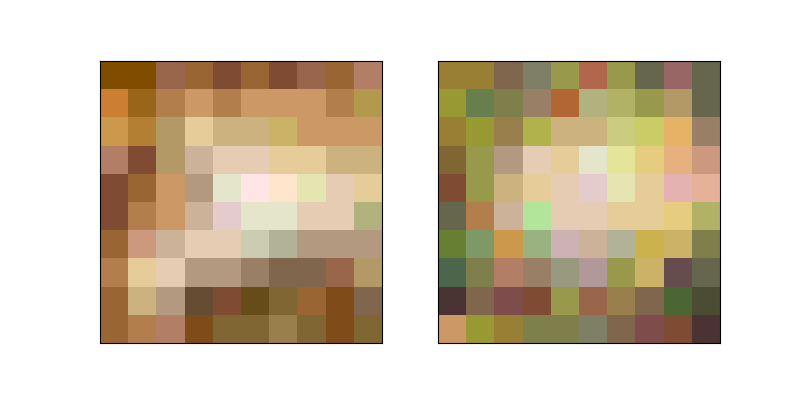

In [108]:
img_i = 0

v = gp_pop_data[img_i].reshape(-1, 1)
p = w @ v
c = p + (lat_ex @ p)
winners = cp.argsort(c, axis=0)[-n_w:]
mask = cp.zeros((N, 1))
mask[winners] = 1
o = mask * p
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(decode_pop(v.reshape(s_len, -1, 3).get(), pop_size))

plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(decode_pop(r.reshape(s_len, -1, 3).get(), pop_size, thresh=0.5))

plt.show()

array([0.94948589])

In [66]:
cp.min(w)

array(1.99782782e-92)

In [94]:
float(cp.mean(w[3]))

0.0023442431857956347

In [76]:
w.get()

array([[4.12642809e-003, 5.20043460e-003, 7.46890011e-003, ...,
        9.38362378e-015, 4.33324983e-026, 1.38797456e-033],
       [3.62696871e-003, 3.94144090e-003, 2.84006736e-003, ...,
        3.02542973e-003, 2.63915910e-002, 2.71474882e-005],
       [4.18087332e-003, 3.87139775e-003, 4.94401983e-003, ...,
        6.08511774e-002, 4.32292015e-002, 3.62789394e-002],
       ...,
       [3.04381598e-003, 4.55393071e-003, 2.41995269e-003, ...,
        2.55513093e-223, 2.82553884e-220, 3.65479527e-225],
       [1.79115302e-003, 5.54921952e-003, 5.28179894e-003, ...,
        1.14379491e-175, 2.88427853e-155, 1.31090995e-139],
       [3.13435597e-003, 3.43571071e-003, 5.47132353e-003, ...,
        6.83778124e-076, 1.24631812e-054, 8.16039756e-062]])